In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers, regularizers, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
%matplotlib inline

### Data gathering and preprocessing

#### The dataset used here consists of the images of the vehicles, and the task here is to classify them either as 'Emergency vehicle', or not. The number of images used here will be reduced to 800.

In [2]:
path = '/Users/skylark/Desktop/Misc/cv/train_SOaYf6m/'
data = pd.read_csv('/Users/skylark/Desktop/Misc/cv/train_SOaYf6m/train.csv')

In [9]:
new_data = data.sample(800)

0    464
1    336
Name: emergency_or_not, dtype: int64

In [12]:
new_data.reset_index(drop=True, inplace=True)

In [13]:
new_data

,image_names,emergency_or_not
0,1217.jpg,0
1,799.jpg,1
2,844.jpg,1
3,1759.jpg,0
4,1193.jpg,0
...,...,...
795,806.jpg,1
796,626.jpg,1
797,133.jpg,1
798,1345.jpg,0


In [15]:
images = []
for img in new_data.image_names:
    path_img = path+'images/'+img
    images.append(image.img_to_array(image.load_img(path=path_img, target_size=(224,224))))

In [21]:
images = np.array(images)
images.shape

(800, 224, 224, 3)

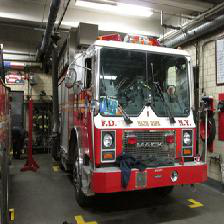

In [20]:
image.load_img(path=path_img, target_size=(224,224))

In [22]:
target = new_data.emergency_or_not

In [25]:
train_x, test_x, train_y, test_y = train_test_split(images, target, random_state = 42, test_size=0.3)

### Building ResNet model

#### The resnet model will be trained using only 560

In [41]:
len(train_x)

560

In [23]:
resnet = ResNet50(include_top=False, input_shape=(224,224,3))

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94773248/94765736 [==============================] - 34s 0us/step


In [27]:
flag = False

for layer in resnet.layers:
    if layer.name in ['conv5_block3_1_conv','conv5_block3_1_bn','conv5_block3_1_relu','conv5_block3_2_conv','conv5_block3_2_bn',
 'conv5_block3_2_relu','conv5_block3_3_conv','conv5_block3_3_bn','conv5_block3_add','conv5_block3_out']:
        flag = True
            
    if flag == True:
        layer.trainable = True
    else:
        layer.trainable = False

In [29]:
x = layers.Flatten()(resnet.output)
final = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs = resnet.input, outputs = final)
model.summary()

Model: "functional_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [30]:
model.compile(optimizer=optimizers.RMSprop(2e-5), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_x, train_y, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
14/14 [==============================] - 58s 4s/step - loss: 0.6860 - acc: 0.7054 - val_loss: 0.3127 - val_acc: 0.8929
Epoch 2/10
14/14 [==============================] - 72s 5s/step - loss: 0.1315 - acc: 0.9665 - val_loss: 0.2661 - val_acc: 0.9107
Epoch 3/10
14/14 [==============================] - 63s 4s/step - loss: 0.0519 - acc: 0.9978 - val_loss: 0.2545 - val_acc: 0.9107
Epoch 4/10
14/14 [==============================] - 73s 5s/step - loss: 0.0277 - acc: 1.0000 - val_loss: 0.2278 - val_acc: 0.9196
Epoch 5/10
14/14 [==============================] - 60s 4s/step - loss: 0.0139 - acc: 1.0000 - val_loss: 0.2304 - val_acc: 0.9196
Epoch 6/10
14/14 [==============================] - 59s 4s/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.2042 - val_acc: 0.9375
Epoch 7/10
14/14 [==============================] - 62s 4s/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.2410 - val_acc: 0.9107
Epoch 8/10
14/14 [==============================] - 59s 4s/step - loss: 0.0021 - acc: 1.00

In [35]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

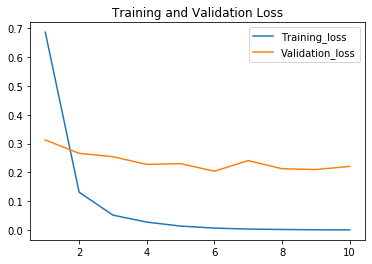

In [39]:
plt.plot(range(1,11), loss, label='Training_loss')
plt.plot(range(1,11), val_loss, label='Validation_loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

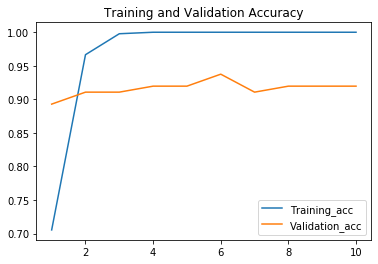

In [40]:
plt.plot(range(1,11), acc, label='Training_acc')
plt.plot(range(1,11), val_acc, label='Validation_acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [31]:
model.evaluate(test_x, test_y)

8/8 [==============================] - 20s 3s/step - loss: 0.2984 - acc: 0.9000


[0.29839277267456055, 0.8999999761581421]

#### The Resnet model trained using only 560 images, gave an accuracy of 89.999..% on the validation set.